In [49]:
# 🧠 Импорт библиотек
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import io
import asyncio
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

import os
import json
import shutil
import zipfile

import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import re

from sklearn.utils import class_weight
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers # и так далее
from tensorflow.keras.optimizers.experimental import AdamW


In [51]:
print(tf.__version__)

2.9.1


In [53]:
kaggle_path = os.path.expanduser("~/Desktop/kaggle.json")
print("Файл существует:", os.path.exists(kaggle_path))

Файл существует: True


In [238]:
df=pd.read_csv("all_letters_info.csv")

df = df[["file", "letter"]]
df["letter"] = df["letter"].str.lower()

# Для русского алфавита (проверь свои данные! если латиница — смени паттерн)
df = df[df["letter"].apply(lambda x: bool(re.match(r'^[а-яё]$', x)))]

df = df.dropna().drop_duplicates()
df = df.rename(columns={"file": "filename", "letter": "label"})

# Классы в виде индексов (для Keras)
classes = sorted(df["label"].unique())
label2idx = {label: idx for idx, label in enumerate(classes)}
df["label_idx"] = df["label"].map(label2idx)

print(df.head())

    filename label  label_idx
0  01_01.png     а          0
1  01_02.png     а          0
2  01_03.png     а          0
3  01_04.png     а          0
4  01_05.png     а          0


In [240]:
# 2. Преобразуем в числовые метки
#class_names = sorted(df["label"].unique())
#label_to_index = {name: idx for idx, name in enumerate(class_names)}
#df["label"] = df["label"].map(label_to_index)

#2. Преобразуем в числовые метки
class_names = sorted(df["label"].unique())
label_to_index = {name: i for i, name in enumerate(class_names)}
df["label"] = df["label"].map(label_to_index)

# 3. Подготавливаем входы и выходы
filenames = df["filename"].values
labels = df["label"].values.astype(np.int32)  # или int64, главное — НЕ one-hot
#labels = tf.keras.utils.to_categorical(df["label"].values, num_classes=len(class_names)).astype('float32')

In [242]:
#def tf_process_example(filename, label):
    # Преобразуем путь для TensorFlow (Windows -> Unix style)
    #base_path = "~/Desktop/all_letters_image/all_letters_image"
    #img_path = tf.strings.join([base_path, filename])
    #image = tf.io.read_file(img_path)
    #image = tf.image.decode_png(image, channels=1)
    #image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.image.resize(image, [28, 28])
    #return image, label

def tf_process_example(filename, label):
     # 👈 приводим к строке
    img_path = tf.strings.join(["/Users/elmansulejmanov/Desktop/all_letters_image/all_letters_image/", filename])
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [28, 28])
    return image, label

#"~/Desktop/all_letters_image/all_letters_image/"

In [244]:
def augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.05)
    image = tf.image.random_contrast(image, 0.95, 1.05)
    return image, label

In [246]:
rare_classes = [2,0,16,32,25,29,19,18,26,20,23,14,17,4,27,28]
rare_df = df[df['label'].isin(rare_classes)]
# удваиваем редкие примеры в обучающей выборке:
augmented_df = pd.concat([df, rare_df]*3)
# аугментации только для редких классов
def augment_rare(image, label):
    if label in rare_classes:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        # и еще несколько преобразований...
    return image, label

In [248]:
train_filenames, val_filenames, train_labels, val_labels = train_test_split(
    filenames, labels, test_size=0.2, random_state=42)

# Применяем правильно: сначала обрабатываем файлы, потом фильтруем
train_ds = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
train_ds = train_ds.map(tf_process_example)     # Загружаешь картинки из файлов
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)   # 👈 Вот тут аугментация!
train_ds = train_ds.shuffle(1000).batch(256).prefetch(tf.data.AUTOTUNE)


val_ds = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
val_ds = val_ds.map(tf_process_example)
val_ds = val_ds.batch(256).prefetch(tf.data.AUTOTUNE)

In [250]:


model = models.Sequential([
    layers.Input(shape=(28,28,1)),  # для чёрно-белых,
    layers.Conv2D(128, (3, 3), padding='valid', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=(2,2), padding='valid'),
    layers.Conv2D(256, (3, 3), padding='valid', activation='relu',kernel_regularizer=regularizers.l2(0.1)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.1)),
    layers.Dropout(0.1),
    layers.Dense(33, activation='softmax')  # 👈 вот тут! 33 нейрона вместо len
])


In [254]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # 👈 ВАЖНО #'categorical_crossentropy',
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
)
print(history.history.keys())

Epoch 1/100
45/45 [==============================] - 20s 433ms/step - loss: 84.6894 - accuracy: 0.1218 - val_loss: 31.5097 - val_accuracy: 0.0328
Epoch 2/100
45/45 [==============================] - 19s 432ms/step - loss: 16.9676 - accuracy: 0.3828 - val_loss: 11.2024 - val_accuracy: 0.0324
Epoch 3/100
45/45 [==============================] - 20s 441ms/step - loss: 7.9532 - accuracy: 0.5742 - val_loss: 8.9808 - val_accuracy: 0.0356
Epoch 4/100
45/45 [==============================] - 21s 457ms/step - loss: 6.1639 - accuracy: 0.6432 - val_loss: 7.8059 - val_accuracy: 0.0282
Epoch 5/100
45/45 [==============================] - 21s 469ms/step - loss: 5.0864 - accuracy: 0.6653 - val_loss: 6.9832 - val_accuracy: 0.0409
Epoch 6/100
45/45 [==============================] - 20s 444ms/step - loss: 4.3710 - accuracy: 0.6780 - val_loss: 6.3676 - val_accuracy: 0.0585
Epoch 7/100
45/45 [==============================] - 20s 447ms/step - loss: 3.8598 - accuracy: 0.6718 - val_loss: 5.8894 - val_accur

In [256]:
model.save("model2.keras")  # 👈 новый формат

1/1 [==============================] - 0s 37ms/step


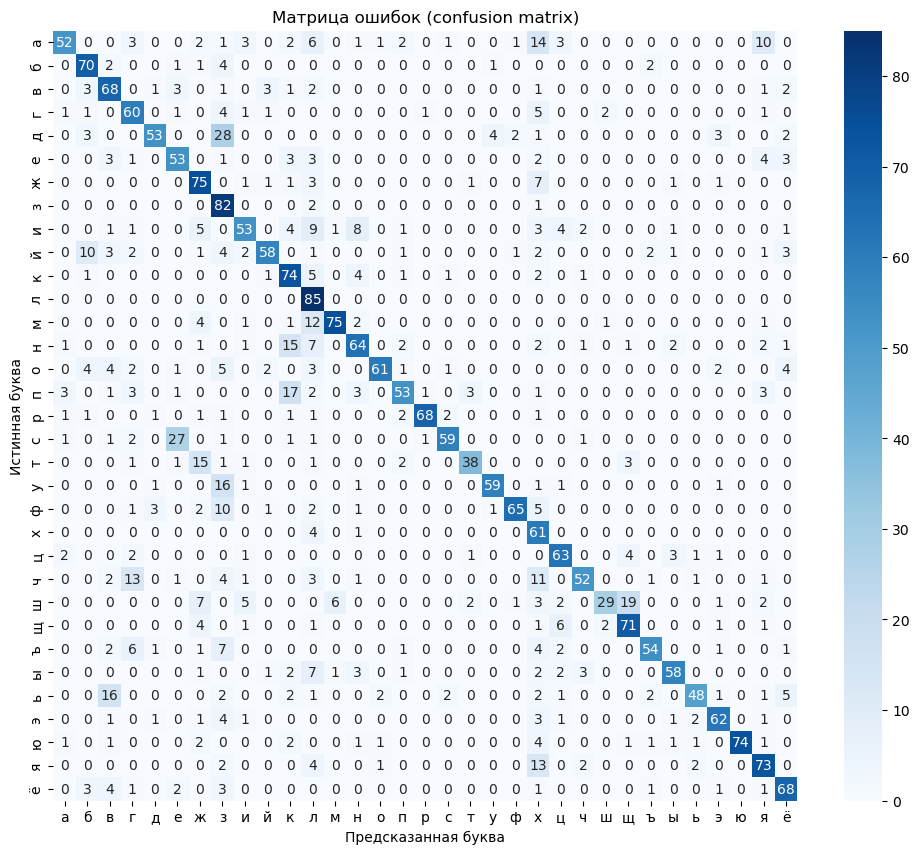

In [258]:
# Получим предсказания модели
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())                          # настоящие метки
    y_pred.extend(tf.argmax(preds, axis=1).numpy())        # предсказания
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Предсказанная буква")
plt.ylabel("Истинная буква")
plt.title("Матрица ошибок (confusion matrix)")
plt.show()

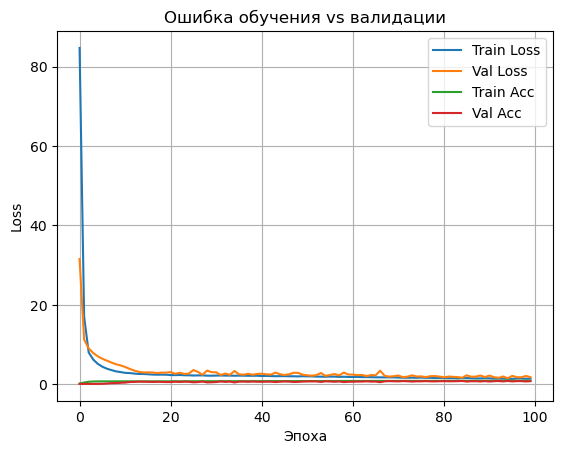

In [259]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Ошибка обучения vs валидации")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

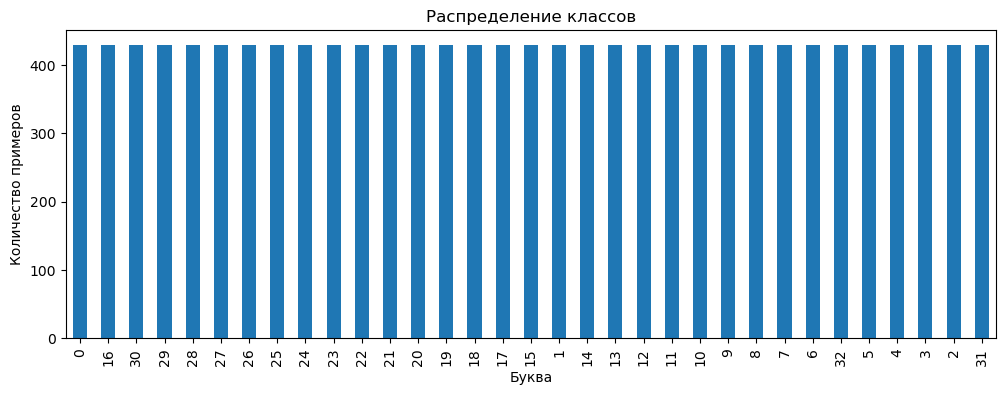

In [202]:
df["label"].value_counts().plot(kind="bar", figsize=(12, 4))
plt.title("Распределение классов")
plt.xlabel("Буква")
plt.ylabel("Количество примеров")
plt.show()

In [226]:
letters = [
    'а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м',
    'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ',
    'ъ', 'ы', 'ь', 'э', 'ю', 'я'
]


# Пример: cm — confusion matrix (33x33)
#letters — список букв, индекс 0='а', 1='б', ..., 32='я'

errors = []
for i in range(len(letters)):
    for j in range(len(letters)):
        if i != j and cm[i, j] > 0:
            errors.append({
                "Буква (правильная)": letters[i],
                "Индекс буквы": i,
                "Ошибочно предсказано как": letters[j],
                "Индекс предсказания": j,
                "Кол-во ошибок": cm[i, j]
            })

# Сортируем по количеству ошибок по убыванию
errors_df = pd.DataFrame(errors)
errors_df = errors_df.sort_values(by="Кол-во ошибок", ascending=False)

print(errors_df)


    Буква (правильная)  Индекс буквы Ошибочно предсказано как  \
57                   д             4                        т   
91                   з             8                        м   
251                  щ            26                        х   
83                   ж             7                        т   
240                  ч            24                        ш   
..                 ...           ...                      ...   
144                  м            13                        т   
149                  м            13                        ю   
150                  н            14                        д   
151                  н            14                        ж   
304                  я            32                        ь   

     Индекс предсказания  Кол-во ошибок  
57                    19             13  
91                    13             12  
251                   22             12  
83                    19             12  
240      

In [228]:
print(errors_df.head(5))

    Буква (правильная)  Индекс буквы Ошибочно предсказано как  \
57                   д             4                        т   
91                   з             8                        м   
251                  щ            26                        х   
83                   ж             7                        т   
240                  ч            24                        ш   

     Индекс предсказания  Кол-во ошибок  
57                    19             13  
91                    13             12  
251                   22             12  
83                    19             12  
240                   25             11  


In [232]:
print(pd.Series(labels).value_counts())

2     3
0     2
16    2
32    2
25    2
29    1
19    1
18    1
26    1
20    1
23    1
14    1
17    1
4     1
27    1
28    1
Name: count, dtype: int64
